In [1]:
import numpy as np
import pandas as pd
import time
from collections import OrderedDict
from sklearn import preprocessing
from matplotlib import pyplot as plt
import faiss

# Data Preparation

In [ ]:
%%time
#200000 compounds with 469 features
all_features = pd.read_csv("c2vpoint2m.txt.gz", sep="\t", header=None)

In [ ]:
#make the compound names the index
all_features.set_index(0, inplace=True)

In [ ]:
%%time
#725634 compounds with target and activity
cgan = pd.read_csv("activities.txt.gz", sep="\t")

In [ ]:
#we are only interested in the compounds whose target is EGFR
egfr_activity = cgan[cgan['target'] == 'EGFR'].set_index('compound')

In [ ]:
#separate into two dataframes, one with active compounds
egfr_active = egfr_activity[egfr_activity['activity'] >= 6]
egfr_active_compounds = egfr_active.index.values

In [ ]:
#and one with inactive ones
egfr_inactive = egfr_activity[egfr_activity['activity']  < 6]
egfr_inactive_compounds = egfr_inactive.index.values

In [ ]:
#5275 compounds with EGFR target and 469 features
egfr_features = pd.read_csv("egfr.c2v.txt", sep="\t", header=None).set_index(0)

In [ ]:
#isolate the names for easier access
egfr_compounds = egfr_features.index.values

In [ ]:
#make dataframes with features for the active and inactive compounds
egfr_active_features = egfr_features.loc[egfr_active_compounds]
egfr_inactive_features = egfr_features.loc[egfr_inactive_compounds]

In [ ]:
#scale the data so that each feature is normalized and can be compared to other features
min_max_scaler = preprocessing.MinMaxScaler() #fits data between 0 and 1

In [ ]:
#normalize the active compounds
egfr_active_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_active_features), 
                                         index=egfr_active_features.index)

In [ ]:
#normalize the inactive compounds
egfr_inactive_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_inactive_features), 
                                           index=egfr_inactive_features.index)

In [ ]:
#remove duplicates from all_features - can also use DataFrame.drop_duplicates()
all_features_cleaned = all_features.loc[list(set(all_features.index.values) - set(egfr_compounds))]

In [ ]:
#normalize the database
all_features_cleaned_norm = pd.DataFrame(min_max_scaler.fit_transform(all_features_cleaned), index=all_features_cleaned.index)

# Logic Creation

In [ ]:
def dataprep(active, rest, size, seed):
    #create the query from a random sample of the data
    size = int(active.shape[0] * size + .5)
    query = active.sample(n=size, random_state=seed)
    
    #remove the query, then concatenate the remaining data for training
    sub = list(set(active.index.values) - set(query.index.values))
    active_minus_query = active.loc[sub]
    database = pd.concat([active_minus_query] + rest)
    
    return database, query

In [ ]:
def buildFaissModel(database, n_neighbors, algorithm, metric):
    #some faiss indexes require additional arguments
    if args:
        index = getattr(faiss, 'Index' + index_type)(database.shape[1], *args)
    else:
        index = getattr(faiss, 'Index' + index_type)(database.shape[1])
        
    #IndexPQ doesn't automatically train    
    if index_type == 'PQ':
        index.train(np.ascontiguousarray(database.values, 'float32'))
 
    #faiss indexes require the data to be a contiguous numpy array of type float32


    #train the model
    start = time.time()
    index.add(np.ascontiguousarray(database.values, 'float32'))
    end = time.time()
    
    build_time = end - start
    
    return index, build_time

In [ ]:
def runFaissQuery(model, query, n_neighbors, database, active):
    #k is the number of neighbors to find
    #run the query
    start = time.time()
    distances, indices = model.search(np.ascontiguousarray(query.values, 'float32'), n_neighbors)
    end = time.time()
    
    query_time = end - start
    
    #assess the quality of the results - how many of the neighbors are in the success dataframe
    sum = 0
    for i in indices:
        count = 0
        for j in i:
            if database.index.values[j] in active.index.values:
                count += 1
        sum += count / float(k)
    average = sum / query.shape[0]
    
    return average, query_time

In [ ]:
#active: the dataframe containing the compounds that you want to receive back: in this case, egfr_active
#rest: a list of other dataframes that will complete the database
#size: proportion of active that is sampled for the query
#n_neighbors: the number of neighbors found for each compound in the query
#index_type: the index used for the model
#seed: the random seed used for sampling
#args: additional arguments used for some of the indexes
def faissNN(active, rest, size, n_neighbors, index_type, seed, args=[]):
    #prepare the data
    database, query = dataprep(active, rest, size, seed)
    
    #build the model
    model, build_time = buildFaissModel(database, n_neighbors, index_type, args)
    
    #run the query
    average, query_time = runFaissQuery(model, query, n_neighbors, database, active)
    
    #return the results in a table
    d = OrderedDict({'algorithm/index':[index_type], 'metric':[None], 'n_neighbors':[n_neighbors], 
                     'query size':[size], 'build time (s)':[build_time], 'query time (s)':[query_time], 
                     'quality':[average], 'seed':[seed]})
    
    return pd.DataFrame(data=d)

# Tests

In [2]:
faiss_results = pd.DataFrame()

In [ ]:
#faiss brute-force
#flatl2 is euclidean, flatip is cosine
temp = []
for index in ['FlatL2', 'FlatIP']:
    for seed in range(5):
        temp.append(faissNN(active=egfr_active_features_norm, rest=[stuff_cleaned_norm, egfr_inactive_features_norm],
                           size=0.2, n_neighbors=100, index_type=index, seed=seed))
faiss_results = pd.concat([faiss_results] + temp)

In [ ]:
#faiss HNSW (Hierarchical Navigable Small World)
#extra argument is number of subquantizers (I think - the documentation is a little sparse)
temp = []
for seed in range(5):
    temp.append(faissNN(egfr_active_features_norm, [stuff_cleaned_norm, egfr_inactive_features_norm],
                       0.2, 100, 'HNSWFlat', seed, args=[64]))
faiss_results = pd.concat([faiss_results] + temp)

In [ ]:
#faiss LSH (Locality-Sensitive Hashing)
#extra argument is n_bits used for each vector
temp = []
for seed in range(5):
    temp.append(faissNN(egfr_active_features_norm, [stuff_cleaned_norm, egfr_inactive_features_norm],
                       0.2, 100, 'LSH', seed, [256]))
faiss_results = pd.concat([faiss_results] + temp)

In [ ]:
#faiss PQ (product quantizer)
#extra arguments are number of subquantizers and n_bits
temp = []
for seed in range(5):
    temp.append(faissNN(egfr_active_features_norm, [stuff_cleaned_norm, egfr_inactive_features_norm],
                       0.2, 100, 'PQ', seed, [1, 8]))
faiss_results = pd.concat([faiss_results] + temp)

In [24]:
faiss_results

,algorithm/index,metric,n_neighbors,query size,build time (s),query time (s),quality,seed
0,FlatL2,NaN,100,0.2,1.074075,0.973394,0.998022,0
1,FlatL2,NaN,100,0.2,0.950572,0.689927,0.996231,1
2,FlatL2,NaN,100,0.2,0.953306,0.707237,0.997836,2
3,FlatL2,NaN,100,0.2,0.947964,0.745277,0.998507,3
4,FlatL2,NaN,100,0.2,0.976736,0.732952,0.998433,4
5,FlatIP,NaN,100,0.2,0.961938,0.644529,0.997519,0
6,FlatIP,NaN,100,0.2,0.928212,0.686473,0.996045,1
7,FlatIP,NaN,100,0.2,0.917398,0.649637,0.997369,2
8,FlatIP,NaN,100,0.2,0.926311,0.601673,0.999608,3
9,FlatIP,NaN,100,0.2,0.921139,0.641527,0.999384,4


In [26]:
faiss_results[['algorithm/index', 'build time (s)', 'query time (s)']].groupby(
    ['algorithm/index']).describe()

# Graphs

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
faiss_results = pd.read_csv("faiss_results.txt")

In [12]:
faiss_results = faiss_results[['algorithm/index', 'metric', 'n_neighbors', 
                                  'query size', 'build time (s)', 'query time (s)', 'quality', 'seed']]

In [13]:
a = faiss_results

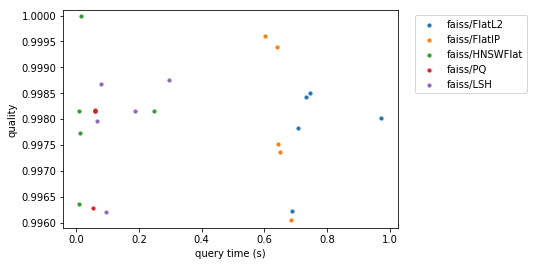

In [14]:
#graph of query time vs quality for each index
plt.figure()
for i in range(0, 25, 5):
    plt.scatter(a[i:i+5]['query time (s)'], a[i:i+5]['quality'], s=10)
plt.ylim(0.9959, 1.0001)
plt.xlabel('query time (s)')
plt.ylabel('quality')
plt.legend(['faiss/FlatL2', 'faiss/FlatIP', 'faiss/HNSWFlat', 'faiss/PQ', 'faiss/LSH'], bbox_to_anchor=(1.4, 1))
plt.show()

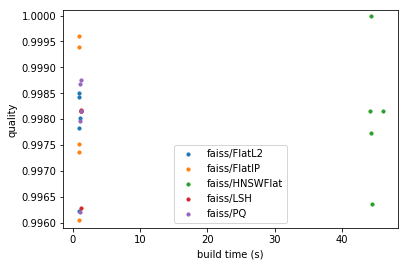

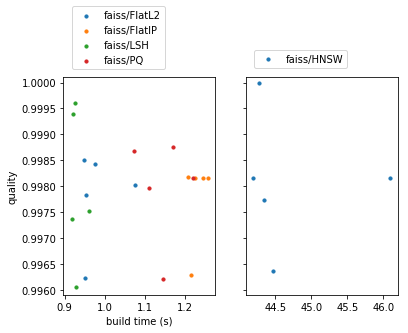

In [42]:
#graph of build time vs quality for each index
plt.figure()
for i in range(0, 25, 5):  
    plt.scatter(a[i:i+5]['build time (s)'], a[i:i+5]['quality'], s=10)

plt.ylim(0.9959, 1.0001)
plt.xlabel('build time (s)')
plt.ylabel('quality')
plt.legend(['faiss/FlatL2', 'faiss/FlatIP', 'faiss/HNSWFlat', 'faiss/LSH', 'faiss/PQ'])

#broken x-axis
f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
for i in range(0, 10, 5):
    ax.scatter(a[i:i+5]['build time (s)'], a[i:i+5]['quality'], s=10)
    ax.scatter(a[i+15:i+20]['build time (s)'], a[i+15:i+20]['quality'], s=10)

ax2.scatter(a[10:15]['build time (s)'], a[10:15]['quality'], s=10)

plt.ylim(0.9959, 1.0001)
    
ax.set_xlabel('build time (s)')
ax.set_ylabel('quality')

ax.legend(['faiss/FlatL2', 'faiss/FlatIP', 'faiss/LSH', 'faiss/PQ'], bbox_to_anchor=(0.7, 1.35))
ax2.legend(['faiss/HNSW'], bbox_to_anchor=(0.7, 1.15))

plt.show()

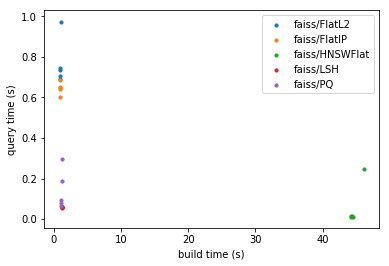

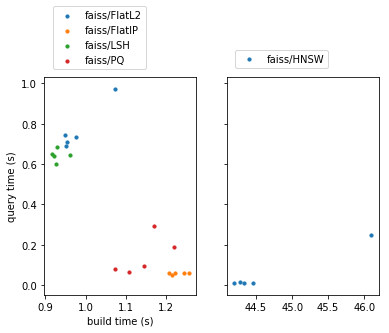

In [22]:
#graph of build time vs query time for each of the algorithm/metric combinations
#lower left is better
plt.figure()
for i in range(0, 25, 5):  
    plt.scatter(a[i:i+5]['build time (s)'], a[i:i+5]['query time (s)'], s=10)

plt.xlabel('build time (s)')
plt.ylabel('query time (s)')
plt.legend(['faiss/FlatL2', 'faiss/FlatIP', 'faiss/HNSWFlat', 'faiss/LSH', 'faiss/PQ'])

#broken x-axis
f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
for i in range(0, 10, 5):
    ax.scatter(a[i:i+5]['build time (s)'], a[i:i+5]['query time (s)'], s=10)
    ax.scatter(a[i+15:i+20]['build time (s)'], a[i+15:i+20]['query time (s)'], s=10)

ax2.scatter(a[10:15]['build time (s)'], a[10:15]['query time (s)'], s=10)
    
ax.set_xlabel('build time (s)')
ax.set_ylabel('query time (s)')

ax.legend(['faiss/FlatL2', 'faiss/FlatIP', 'faiss/LSH', 'faiss/PQ'], bbox_to_anchor=(0.7, 1.35))
ax2.legend(['faiss/HNSW'], bbox_to_anchor=(0.7, 1.15))

plt.show()